In [1]:
import tensorflow_addons as tfa

from definitions import *
from trainTestValSplit import getTrainTestValSplit
from preProcessing import preProcess
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
train_concat, test_concat, val_concat = getTrainTestValSplit(
    _dataset_path=f'{ROOT_DIR}/dataset/ExtraSensory/Processed_outliers_with_labels'
)

/Volumes/SEAGATE/code/ML4QS-Assignment3/dataset/ExtraSensory/Processed_outliers_with_labels/098A72A5-E3E5-4F54-A152-BBDA0DF7B694.csv


In [3]:
len(test_concat)

66128

In [4]:
train_x, train_y = preProcess(train_concat)
test_x, test_y = preProcess(test_concat)
val_x, val_y = preProcess(val_concat)

In [5]:
len(test_y)

66128

In [6]:
n_neurons: int = 1024
n_features: int = len(train_x.columns)

In [7]:
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()
val_x = val_x.to_numpy()
val_y = val_y.to_numpy()

In [8]:
train_y = encodeTarget(train_y)
test_y = encodeTarget(test_y)
val_y = encodeTarget(val_y)

In [9]:
train_x = reshape_and_truncate(train_x, (-1, window_size, n_features))
train_y = reshape_and_truncate(train_y, (-1, window_size, len(main_activity_label_classes)))

test_x = reshape_and_truncate(test_x, (-1, window_size, n_features))
test_y = reshape_and_truncate(test_y, (-1, window_size, len(main_activity_label_classes)))

val_x = reshape_and_truncate(val_x, (-1, window_size, n_features))
val_y = reshape_and_truncate(val_y, (-1, window_size, len(main_activity_label_classes)))

In [10]:
with tf.device('/cpu:0'):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=early_stopping_patience,
                                                      mode='min',
                                                      restore_best_weights=True)
    model = tf.keras.Sequential()

    layer = tf.keras.layers.Normalization(axis=-1)
    layer.adapt(train_x)
    model.add(layer)

    model.add(tfa.layers.ESN(n_neurons,
                             return_sequences=True,
                             input_shape=(train_x.shape[1], train_x.shape[2])))
    model.add(tf.keras.layers.Dense(n_y,
                                    activation=tf.keras.activations.softmax))

    model.summary()
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
    history = model.fit(x=train_x,
                        y=train_y,
                        epochs=epochs,
                        validation_data=(val_x, val_y),
                        callbacks=[early_stopping],
                        batch_size=batch_size)
    predict = model.predict(test_x)

Metal device set to: Apple M1 Pro


2022-06-25 20:13:57.184776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-25 20:13:57.184896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-25 20:13:57.210359: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, None, 51)         103       
 n)                                                              
                                                                 
 esn (ESN)                   (None, None, 1024)        1101824   
                                                                 
 dense (Dense)               (None, None, 7)           7175      
                                                                 
Total params: 1,109,102
Trainable params: 7,175
Non-trainable params: 1,101,927
_________________________________________________________________
Epoch 1/100
650/650 [==============================] - 10s 15ms/step - loss: 1.0012 - val_loss: 0.9285
Epoch 2/100
650/650 [==============================] - 12s 18ms/step - loss: 0.8262 - val_loss: 0.8854
Epoch 3/100
650/650 [=============

In [11]:
gold_labels = get_labels(test_y)
predicted_labels = get_labels(predict)

In [12]:
print(f'F1: {f1_score(gold_labels, predicted_labels, average="weighted")}')
print(f'Precision: {precision_score(gold_labels, predicted_labels, average="weighted", zero_division=0)}')
print(f'Recall: {recall_score(gold_labels, predicted_labels, average="weighted", zero_division=0)}')
# F1: 0.7540022425861407
# Precision: 0.7466318028043031
# Recall: 0.7667876588021778

F1: 0.7528760950636856
Precision: 0.7434636139741705
Recall: 0.7690562613430127


In [13]:
export_dir: str = 'Plots/ESN'

n_classes_conf_matrix: 6612


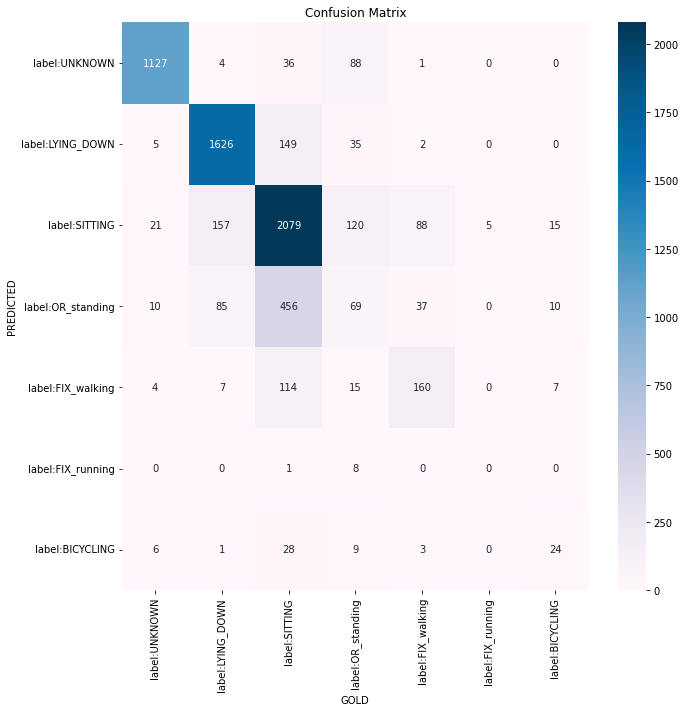

In [14]:
plot_conf_matrix(gold_labels, predicted_labels, export_dir=export_dir, file_name='confusion_matrix_esn.png')

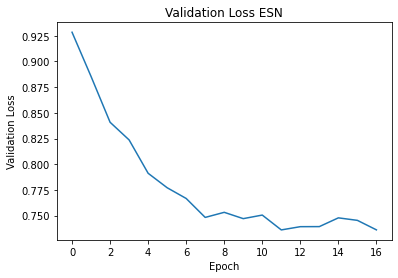

In [15]:
plot_val_loss_progress(history, export_dir=export_dir, file_name='convergence_val_loss_esn.png', model_name='ESN')